# Introduction

This jupyter notebook is prepared as the individual coursework for the COMM061 Natural Language Processing. 
In this project, the [go-emotion dataset](https://github.com/google-research/google-research/blob/master/goemotions/README.md) consisting 54,263 Reddit texts annotated with 28 emotions (including neutral) is used. The objective is to experiment, study and compare different approaches to build NLP pipelines and models for a multi-class classification problem, i.e. the model should be able to identify the emotion label of a given text. Per the coursework requirement, the number of emotions is required to be compressed to 14 (including neutral) instead of 28 emotion classes. Moreover, the original dataset is multi-label, i.e. each sample text will be annotated with more than one emotion. As a result, preliminary data merging and transformation are required to prepare a dataset ready for further analysis. 

This jupyter notebook is separated into 4 parts. In Part 1, preliminary data merging and transformation is carried out to prepare the dataset ready for next stage analysis. In Part 2, simple NLP techniques, including n-gram, stopwords, Bag of Words (BoW) and Term Frequency Inverse Document Frequency (TFIDF) are applied to extract the feature vectors from sample texts. A simple multiple layer perceptron (MLP) is then trained to perform classification task. In Part 3, more advanced feature vectorization technique using prebuilt BERT tokenizer is applied. A model with a Long Short Term Memory (LSTM) layer followed by Fully Connected (FC) MLP layers is built to perform the classification task. In Part 4, we will adopt the transfer learning approach in which prebuilt BERT Transformer followed by FC MLP layers is fine-tuned for the classification task. Accuracy of different approaches are then compared and discussed. The approach with best performance is then selected for the next-stage Group integration project.  


# Part 1 - Data Loading and Emotions Merging

In this part, the text data is going to be loaded from CSV files downloaded from [go-emotion dataset](https://github.com/google-research/google-research/blob/master/goemotions/README.md). We will examine the emotions correlation matrix and perform emotions merging such that 

- the dataset becomes a multi-class instead of multi-label dataset
- total number of emotions including neutral is 14

In [33]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean


Load the data from tsv files. The original datasets are separated into three CSV files (training, test and dev). Because of the need to merge emotions, we will combine them first.

In [34]:
DATA_FOLDER = 'data/full_dataset/'

colnames=['text', 'labels', 'id'] 

df1 = pd.read_csv(os.path.join(DATA_FOLDER, 'dev.tsv'), encoding="utf-8", sep='\t', names=colnames, header=None)
df2 = pd.read_csv(os.path.join(DATA_FOLDER, 'test.tsv'), encoding="utf-8", sep='\t', names=colnames, header=None)
df3 = pd.read_csv(os.path.join(DATA_FOLDER, 'train.tsv'), encoding="utf-8", sep='\t', names=colnames, header=None)

data_full = pd.concat([df1, df2, df3], ignore_index=True)


Examine the data samples. It contains the ID, text and emotion labels. 

In [ ]:
data_full.head()

The emotion codes can be looked up according to the following dictionary provided in the dataset.

In [36]:
# A dictionary for emotion.
emotion_dict = {'0': 'admiration', 
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

To faciliate further merging of emotions, the coded emotion labels will be separated into one-hot encoding columns of emotions. 

In [37]:
for k,v in emotion_dict.items():
    data_full[v]=0

In [38]:
for r in range(0, data_full.shape[0]):
    labels = data_full.iloc[r]['labels'].split(',')
    for lb in labels:
        if emotion_dict.get(lb)!=None:
            data_full.loc[r, emotion_dict.get(lb)]=1

The expanded emotion columns are as follows: 

In [ ]:
data_full.head()

In [40]:
print(f'Total number of rows: {data_full.shape[0]}')


Total number of rows: 54263


Load the emotions.txt 

In [ ]:
with open(os.path.join(DATA_FOLDER, 'emotions.txt'), "r") as f:
    all_emotions = f.read().splitlines()
all_emotions

In the original dataset, emotions (except neutral) are grouped into three sentiment classes: Positive, Negative and Ambiguous. These sentiment classes are useful for us to merge 28 emotions into 14 emotions because only emotions within the same sentiment class will be merged. For example, we will not merge "sadness" with "joy", which is counter-intuitive. 

In [ ]:
with open(os.path.join(DATA_FOLDER, 'sentiment_dict.json'), "r") as f:
    sent_dict = json.loads(f.read())
sent_dict

The distribution table illustrates the percentage of sample text tagged with one or more emotions

In [ ]:
ds_counts = data_full[all_emotions].sum(axis=1).value_counts()
distribution = pd.DataFrame({'Number of Emotions Tagged': ds_counts.index.to_list(),
                             'Count of Samples': ds_counts.to_list(),
                             'Percentage': (100*ds_counts/len(data_full)).to_list() })
distribution

The distribution table illustrates the percentage of emotions in the dataset

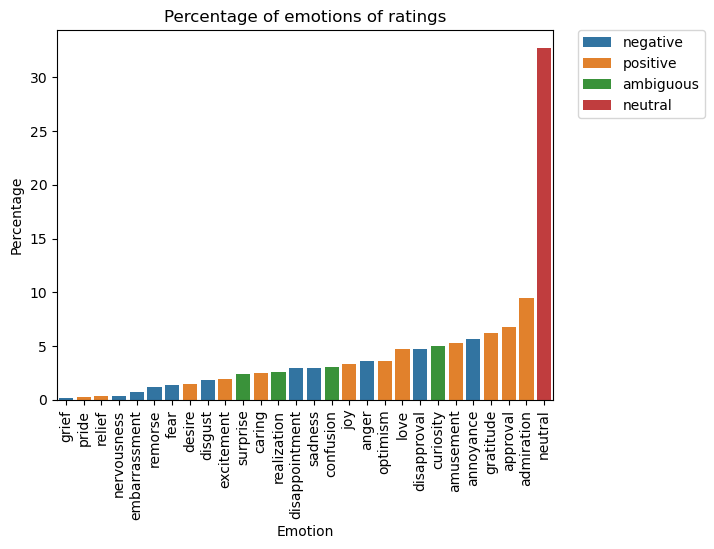

In [44]:
em_counts = data_full[all_emotions].sum(axis=0).sort_values(ascending=True) 
distribution = pd.DataFrame({'Emotion': em_counts.index.to_list(),
                             'Count of Ratings': em_counts.to_list(),
                             'Percentage': (100*em_counts/len(data_full)).to_list(),
                             'Sentiment': 'neutral'})

for k in sent_dict.keys():
    distribution.loc[distribution['Emotion'].isin(sent_dict[k]), 'Sentiment'] = k
    
# ax = distribution.plot.bar(x='Emotion', y='Percentage',figsize=(10,6))
# ax.set_title('Percentage of emotions of ratings')

ax = sns.barplot(x='Emotion', y='Percentage', data=distribution, hue='Sentiment', dodge=False)
plt.title("Percentage of emotions of ratings")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Next the 28 emotions will be combined into 14 emotions. 

The first step is to cope with those samples with multi emotion labels into single label. For samples with multiple emotion labels, we calculate its frequency Freq_per_label_group (dfcum_per_group). We also compute the Freq_per_emotion (dfcum_per_emotion). Then the Freq_per_label_group is normalized by Freq_per_emotion. The "normalized" Freq_per_label_group will have larger value if Freq_per_emotion is small. The concept is similar to the TFIDF to indicate how important a particular emotion for the sample taking into account how popular that emotion appear in other samples. If the emotion is not popular (Freq_per_emotion is low), then the value of normalized Freq_per_label_group will be large. 

Such approach is also equivalent to just retain the emotion label with lowest overall frequency in a multi-label sample. For example, given a sample text is tagged with three emotion labels, "joy", "admiration" and "excitment", since "excitement" is with lowest overall frequnency, we will only retain "excitement" and remove the labels "joy" and "admiration" from the sample. Such approach is also helpful to reduce the  the imbalance of distribution in emotion labels as shown in the chart above. 

In [45]:
dfcum_per_group = data_full.groupby('labels')[all_emotions].sum()
dfcum_per_emotion = data_full[all_emotions].sum(axis=0)

for em in all_emotions:
    total = dfcum_per_emotion.loc[em]
    dfcum_per_group[em] = dfcum_per_group[em].apply(lambda x: x/total)
    

For samples with multiple emotion labels, we only retain the emotion with highest normalized Freq_per_label_group. Other emotion labels of the samples will be removed.

In [46]:
for lbl in dfcum_per_group.index:
    max_em = dfcum_per_group.loc[lbl].idxmax()
    data_full.loc[data_full['labels']==lbl, all_emotions] = 0
    data_full.loc[data_full['labels']==lbl, max_em] = 1


In [ ]:
# Examine the emotion frequency after reduction of output labels

ds_counts = data_full[all_emotions].sum(axis=1).value_counts()
distribution = pd.DataFrame({'Number of Emotions': ds_counts.index.to_list(),
                             'Count of Ratings': ds_counts.to_list(),
                             'Percentage': (100*ds_counts/len(data_full)).to_list() })
distribution


Now all samples have only one emotion label and suitable for multi-class classification. Next, we have to merge different emotions such that only 14 emotions are remained. To do this, we need to consider the correlations among emotions and try to merge those highly correlated with each other. 

<Axes: >

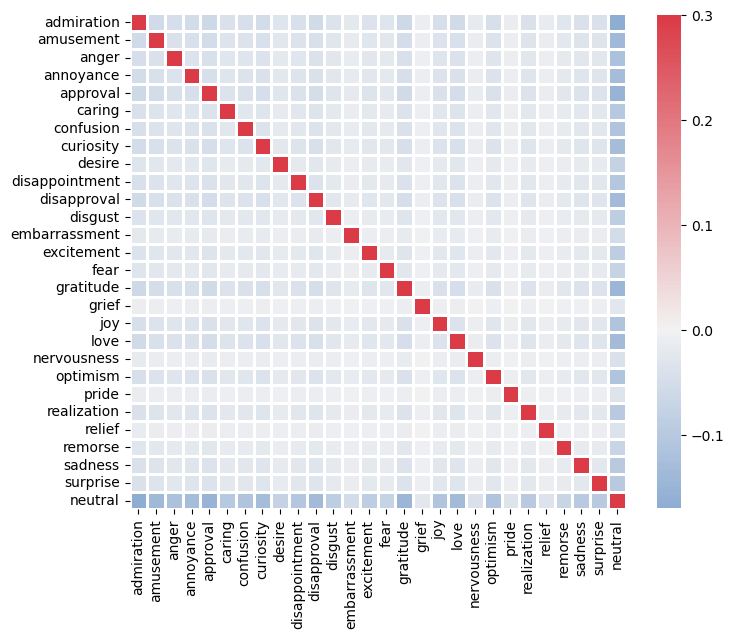

In [48]:
emotions_per_sample = data_full.groupby("id")[all_emotions].sum()
corr_mat = emotions_per_sample.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
  corr_mat,
  cmap=cmap,
  vmax=.3,
  center=0,
  square=True,
  linewidths=0.8,
  cbar_kws={"shrink": 0.8})

We can have a look at the paired correlation coefficients between emotions:

In [ ]:
# To obtain a sorted list of correlated emotion pairs for 
col = corr_mat.columns.to_list()
row = corr_mat.index.to_list()

corr_pairs = {}
for i,em in enumerate(col):
    for j in range(i,len(row)):
        if i!=j: 
            if (col[i] in sent_dict['positive'] and row[j] in sent_dict['positive']) or \
               (col[i] in sent_dict['negative'] and row[j] in sent_dict['negative']) or \
               (col[i] in sent_dict['ambiguous'] and row[j] in sent_dict['ambiguous']):             
                    key = col[i] + ',' + row[j]
                    corr_pairs[key] = corr_mat.loc[row[j]][col[i]]

corr_pairs = {k: v for k, v in sorted(corr_pairs.items(), key=lambda item: abs(item[1]), reverse=True)}

print('The sorted list of correlation coefficient between pair of emotions which are in the same sentiment (positive/negative): ')
corr_pairs

The 28 emotions are then merged into 14 emotions by considering the correlation among emotions and its sentiment categories (positive, negative, ambiguous and neutral). Only emotions in the same sentiment category will be grouped together. 

The following merging scheme is used:


In [50]:
x = (data_full[['amusement','joy','excitement']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "amusement_joy_excitement", x, True)

x = (data_full[['caring', 'desire', 'optimism']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "caring_desire_optimism", x, True)

x = (data_full[['gratitude', 'pride', 'relief']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "gratitude_pride_relief", x, True)

x = (data_full[['curiosity','confusion']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "curiosity_confusion", x, True)

x = (data_full[['fear','nervousness']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "fear_nervousness", x, True)

x = (data_full[['disappointment','embarrassment','grief','remorse','sadness']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "disappointment_embarrassment_grief_remorse_sadness", x, True)

x = (data_full[['anger', 'annoyance', 'disgust']].sum(axis=1)>0).astype(int)
data_full.insert(len(data_full.columns), "anger_annoyance_disgust", x, True)



### Define a list of selected emotions upon merging

In [53]:
selected_emotions = [
'amusement_joy_excitement',
'love',
'caring_desire_optimism',
'gratitude_pride_relief',
'admiration',
'approval',
'realization',
'surprise',
'curiosity_confusion',
'fear_nervousness',
'disappointment_embarrassment_grief_remorse_sadness',
'anger_annoyance_disgust',
'disapproval',
'neutral']

In [54]:
sent_dict['positive'].extend(['amusement_joy_excitement',
                                                      'caring_desire_optimism',
                                                      'gratitude_pride_relief'])

sent_dict['negative'].extend(['fear_nervousness',
                                                      'disappointment_embarrassment_grief_remorse_sadness',
                                                      'anger_annoyance_disgust'])

sent_dict['ambiguous'].extend(['curiosity_confusion'])

The distribution of emotions after meging is shown below:

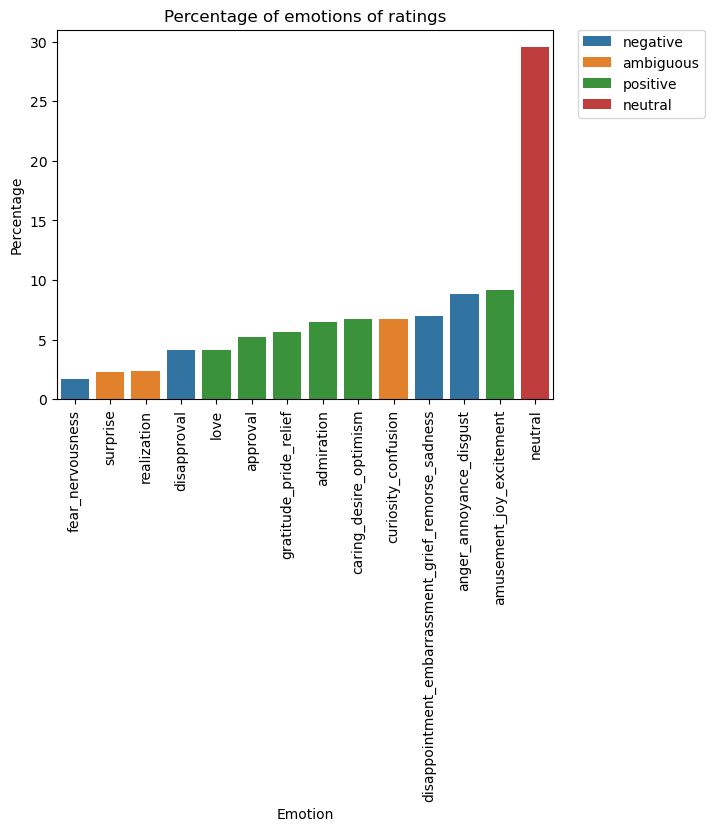

In [57]:
em_counts = data_full[selected_emotions].sum(axis=0).sort_values(ascending=True) 
distribution = pd.DataFrame({'Emotion': em_counts.index.to_list(),
                             'Count of Ratings': em_counts.to_list(),
                             'Percentage': (100*em_counts/len(data_full)).to_list(),
                             'Sentiment': 'neutral'})
# ax = distribution.plot.bar(x='Emotion', y='Percentage',figsize=(10,6))
# ax.set_title('Percentage of emotions of ratings after merging')


for k in sent_dict.keys():
    distribution.loc[distribution['Emotion'].isin(sent_dict[k]), 'Sentiment'] = k
    
distribution

ax = sns.barplot(x='Emotion', y='Percentage', data=distribution, hue='Sentiment', dodge=False)
plt.title("Percentage of emotions of ratings")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Finally, we convert the merged emotion columns and export as csv file 'merged_emotions.csv' for next stage analysis.

In [33]:
data_full['merged_labels'] = data_full[selected_emotions].idxmax(axis=1)
data_full[['text','merged_labels']].to_csv('merged_emotions.csv', encoding='utf-8')